In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline

In [2]:
df = pd.read_csv('car.data.txt',header=None,index_col=False,names=['buying','maint','doors','persons','lug_boot','safety','quality'])


In [3]:
# 同时处理预处理测试集
unknown_data = pd.DataFrame(np.array(['vhigh', 'vhigh', '2', '2', 'small', 'low']).reshape(1,6),columns=['buying','maint','doors','persons','lug_boot','safety'])
unknown_data

,buying,maint,doors,persons,lug_boot,safety
0,vhigh,vhigh,2,2,small,low


In [4]:
alldata=df.append(unknown_data)
alldata.tail()

,buying,doors,lug_boot,maint,persons,quality,safety
1724,low,5more,med,low,more,vgood,high
1725,low,5more,big,low,more,unacc,low
1726,low,5more,big,low,more,good,med
1727,low,5more,big,low,more,vgood,high
0,vhigh,2,small,vhigh,2,NaN,low


## Convert string data to numerical data
## 本例中分类变量数值大小有意义，比如 High-3 > Med-2> low-1，所以不适合用pd.get_dummies 

In [5]:
le = preprocessing.LabelEncoder()

In [6]:
X_encoded=alldata[['buying','maint','doors','persons','lug_boot','safety']].apply(le.fit_transform)

In [7]:
X_test = X_encoded.tail(1)
X = X_encoded[:-1]

In [8]:
y = alldata['quality'][:-1]
y = le.fit_transform(y)

## Build a Random Forest Classifier  

In [9]:
param = {'n_estimators': 200, 'max_depth': 8, 'random_state': 7}
classifier = RandomForestClassifier(**param)
classifier.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=7,
            verbose=0, warm_start=False)

## Cross validation 

In [10]:
from sklearn import cross_validation
accuracy = cross_validation.cross_val_score(classifier, X, y, scoring='accuracy', cv=3)
print(accuracy)

/Users/linzhun/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[ 0.72790295  0.81597222  0.80173913]


In [11]:
print("Accuracy of the classifier: " + str(round(100*accuracy.mean(), 2)) + "%")

Accuracy of the classifier: 78.19%


In [12]:
y_pred = classifier.predict(X_test)
y_pred

array([2])

In [13]:
print("output class: ",le.inverse_transform(y_pred)[0])

output class:  unacc


# Validation Curves

* 上面我们创建了随机森林分类器，那么接下来，（调参时）我们怎么准确地 确定最优的 parameters ？
* 下面，我们处理2个参数：n_estimators 和 max_depth 。它们被称作“超参数Hyperparameters",分类器的性能依赖它们。通过改变超参数，看看性能如何受影响
* validation curves 帮助我们理解一个超参数如何影响train score. 本质上，其他超参数给定固定值，只在规定范围内变化我们感兴趣的超参数


In [14]:
from sklearn.learning_curve import validation_curve 

/Users/linzhun/anaconda/lib/python3.6/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [15]:
classifier = RandomForestClassifier(max_depth=4,random_state=7)  # max_depth为固定值4
parameter_grid = np.linspace(25,200,8).astype(int)  # 均匀分割区间. define our search space 
print(parameter_grid)   # n_estimators 从25-200 取值，迭代8次
train_score, validation_score = validation_curve(classifier, X, y, 'n_estimators', parameter_grid,cv=5)
print(train_score)   # cv=5 折，所以 output 是 8 x 5

[ 25  50  75 100 125 150 175 200]
[[ 0.80680174  0.80824891  0.80752533  0.80463097  0.81358382]
 [ 0.79522431  0.80535456  0.81041968  0.8089725   0.81069364]
 [ 0.80101302  0.80680174  0.81114327  0.81476122  0.8150289 ]
 [ 0.8024602   0.80535456  0.81186686  0.80752533  0.80346821]
 [ 0.80028944  0.80463097  0.81114327  0.80824891  0.81069364]
 [ 0.80390738  0.80535456  0.81041968  0.80969609  0.81647399]
 [ 0.80390738  0.80463097  0.81114327  0.81476122  0.81719653]
 [ 0.80390738  0.80607815  0.81114327  0.81403763  0.81647399]]


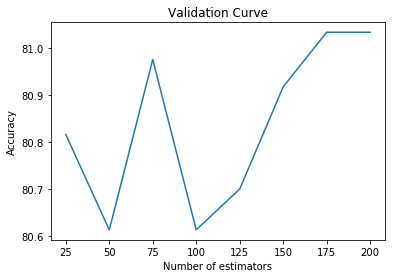

In [16]:
# Plot the curve

plt.figure()
plt.plot(parameter_grid,100*np.average(train_score,axis=1))
plt.title("Validation Curve")
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.show()

[[ 0.71852388  0.70043415  0.70043415  0.70043415  0.69942197]
 [ 0.80607815  0.80535456  0.80752533  0.79450072  0.81069364]
 [ 0.90665702  0.91027496  0.92836469  0.89797395  0.90679191]
 [ 0.97467438  0.96743849  0.96888567  0.97829233  0.96820809]
 [ 0.99421129  0.99710564  0.99782923  0.99855282  0.99277457]]


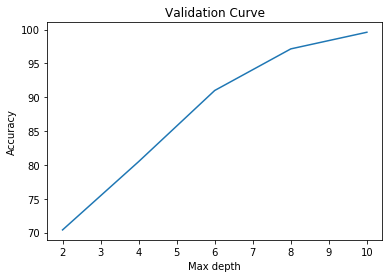

In [17]:
# do the same for the max_depth parameter:
classifier = RandomForestClassifier(n_estimators=20, random_state=7)
parameter_grid = np.linspace(2,10,5).astype(int)
train_score, validation_score = validation_curve(classifier,X,y,'max_depth',parameter_grid,cv=5)
print(train_score)
plt.figure()
plt.plot(parameter_grid,100*np.average(train_score,axis=1))
plt.title("Validation Curve")
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.show()

# Learning Curves

* 学习曲线帮助我们理解 训练集大小对模型的影响
* 这在计算力有限时非常有用

In [18]:
from sklearn.learning_curve import learning_curve


#### LEARNING CURVES ####

Training scores:
 [[ 1.          1.          1.          1.          1.        ]
 [ 1.          1.          0.998       0.998       0.998     ]
 [ 0.99875     0.9975      0.99875     0.99875     0.99875   ]
 [ 0.99818182  0.99545455  0.99909091  0.99818182  0.99818182]]

Validation scores:
 [[ 0.69942197  0.69942197  0.69942197  0.69942197  0.70348837]
 [ 0.74855491  0.65028902  0.76878613  0.76589595  0.70348837]
 [ 0.70520231  0.78612717  0.52312139  0.76878613  0.77034884]
 [ 0.65028902  0.75433526  0.65317919  0.75433526  0.76744186]]


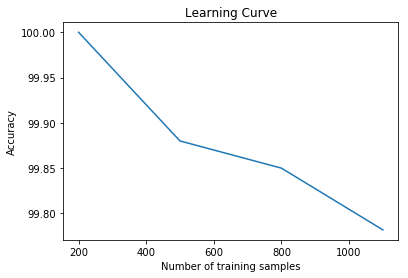

Average:  [ 100.           99.88         99.85         99.78181818]


In [19]:
classifier = RandomForestClassifier(random_state=7)

parameter_grid = np.array([200, 500, 800, 1100])
train_sizes, train_scores, validation_scores = learning_curve(classifier, X, y, train_sizes=parameter_grid,cv=5)

print("\n#### LEARNING CURVES ####")
print("\nTraining scores:\n", train_scores)
print("\nValidation scores:\n", validation_scores)

# Plot the curve
plt.figure()
plt.plot(parameter_grid, 100*np.average(train_scores,axis=1))
plt.title('Learning Curve')
plt.xlabel("Number of training samples")
plt.ylabel("Accuracy")
plt.show()
print("Average: ",100*np.average(train_scores,axis=1))

训练集越小，准确度越高，但也易于过拟合；
训练集越大，消耗的计算资源越多。因此我们需要做权衡。